In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
plt.rcParams.update({'font.size': 14})

# Tune down the saturation of the last four colors
colors = ['dodgerblue', '#F2C14E', '#90BE6D', '#F28482'] + [
    to_rgba(color, alpha=0.6) for color in ['#FF7F50', '#6495ED', '#3CB371', '#9370DB']
]


In [1]:
# Read the log file and clean it

log = "./log/log_4_a100_llama3.2-3B.txt"
with open(log, 'r') as file:
    lines = file.readlines()

# Inject a new line signal for lines with two "Rank" occurrences
cleaned_lines = []
for line in lines:
    if line.count("Rank") > 1:
        parts = line.split("Rank")
        for part in parts[1:]:
            cleaned_lines.append("Rank " + part.strip() + "\n")
    else:
        cleaned_lines.append(line)

# Write the cleaned log to a new file
with open(log, 'w') as file:
    file.writelines(cleaned_lines)


In [5]:
# Print the allreduce kernel time from every rank
ar_times = {rank: {} for rank in range(4)}

# Read the log file
with open(log, 'r') as file:
    for line in file:
        # Match the log line pattern
        match = re.search(r'Rank (\d+) \| Step (\d+) .*? AR Time: ([\d.]+) ms', line)
        if match:
            rank = int(match.group(1))
            step = int(match.group(2))
            ar_time = float(match.group(3))
            ar_times[rank][step] = ar_time

# Create a DataFrame from the extracted data
df = pd.DataFrame(ar_times).sort_index()

# Rename columns to indicate ranks
df.columns = [f'Rank {col}' for col in df.columns]

# Display the table
print(df)

     Rank 0  Rank 1   Rank 2   Rank 3
0   1002.45  891.84  1753.16  1451.98
1    141.09  146.46   117.94   136.21
2    145.17  139.45   118.06   137.20
3    148.34  142.01   119.39   141.84
4    145.32  142.28   119.75   139.99
5    141.88  139.45   117.55   136.21
6    142.29  140.42   117.69   136.30
7    145.11  143.62   117.46   135.36
8    151.31  145.37   117.57   138.34
9    145.38  140.21   117.43   133.71
10   148.11  141.41   117.45   135.60
11   146.16  140.68   117.43   136.76
12   146.15  138.80   117.20   135.10
13   146.16  139.16   117.23   129.27
14   146.35  138.48   117.65   129.49
15   139.98  138.18   117.30   127.78
16   143.33  138.81   117.26   126.45
17   145.61  138.62   117.49   128.72
18   144.16  140.34   117.50   126.72
19   143.38  140.88   117.18   128.29
20   144.67  140.49   117.10   126.41
21   145.73  141.16   117.62   129.81
22   143.74  138.32   117.51   124.48
23   144.33  139.61   117.14   124.76
24   140.28  137.71   117.30   124.50
25   141.90 

Percentage of time each rank has the smallest number:
Rank 2    98.0
Rank 1     2.0
Name: count, dtype: float64


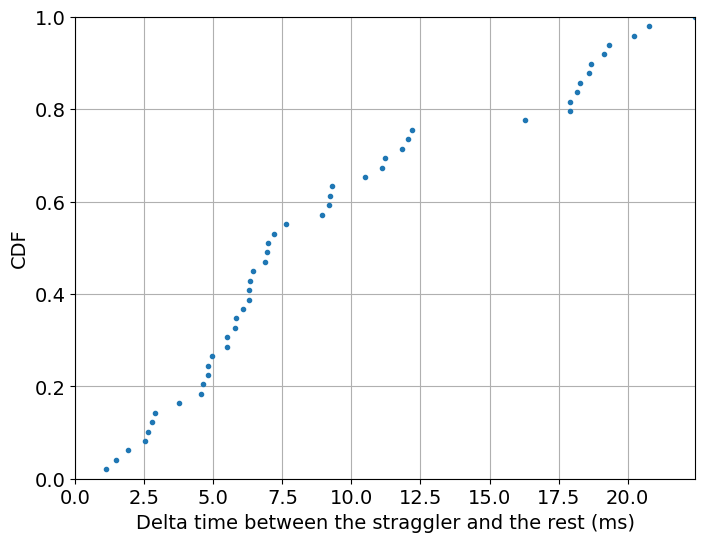

In [7]:
# straggler analysis
import numpy as np

import matplotlib.pyplot as plt

# Compute the difference between the smallest and second smallest values in each row
differences = df.apply(lambda row: np.partition(row, 1)[1] - row.min(), axis=1)

differences = differences[1:]
# Sort the differences to compute the CDF
sorted_differences = np.sort(differences)
cdf = np.arange(1, len(sorted_differences) + 1) / len(sorted_differences)

# Calculate the percentage of time each rank has the smallest number in the row
smallest_counts = (df.idxmin(axis=1).value_counts() / len(df)) * 100
print("Percentage of time each rank has the smallest number:")
print(smallest_counts)

# Plot the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_differences, cdf, marker='.', linestyle='none')
plt.xlabel('Delta time between the straggler and the rest (ms)')
plt.ylabel('CDF')
plt.ylim(0, 1)
plt.xlim(0, sorted_differences.max())
plt.grid()
plt.show()